In [25]:
%pylab inline
#import matplotlib as plt
#import numpy as np
import pandas as pd
import uncertainties
from uncertainties import unumpy as unp
from uncertainties import ufloat
from sympy import *
from numpy import array as array

def gaussian(x, mu, sigma, B, A):
    return A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B,
                  p0=p0)
def sine(x,a,b,c,d):
    import numpy as np
    return a*np.sin(c*x-d)+b

def sinefit_pm(x,y,p0=None):
    return fit_pm(x,y,sine,p0=p0)

def line(x,a,b):
    return a * x + b

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)


def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def errr(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size


Populating the interactive namespace from numpy and matplotlib


In [26]:
%store -r cali
%store -r upper_bound
%store -r lower_bound
print("cali\n",cali)
print("bounds")
print(upper_bound,lower_bound)

cali
 [0.00044244234308799294+/-1.985696919947778e-05
 0.003736509102934345+/-0.005445659683568066]
bounds
0.04733+/-0.00015 -0.01105+/-0.00015


In [27]:
#filenames = ["dx_1.csv","dx_2.csv","dx_3.csv","dx_4.csv","dx_5.csv"]
filename_l,filename_r = "guess_gy",".csv"
#data = [[a_ch1,a_ch2],[b_ch1,b_ch2],[c_ch1,c_ch2],[d_ch1,d_ch2],[e_ch1,e_ch2]]
data= []
for i in [1,2,3,5,""]:
    df = pd.read_csv(filename_l+str(i)+filename_r,index_col=0)
    print("file read",i)
    ch1 = [float(item)for item in df.iloc[1:,0].to_numpy()]
    ch2 = [float(item)for item in df.iloc[1:,1].to_numpy()]
    data.append([array(ch1),array(ch2)])

file read 1
file read 2
file read 3
file read 5
file read 


In [28]:
def analysis(data_sine, data_dip, dist_to_dip=20, printt=0, plott=0,save=0):  
    x = np.arange(len(data_sine))
    if plott:
        plt.plot(x,data_sine,label=0)
        plt.plot(x,data_dip,label=1)
        plt.legend()
        plt.show()

    def siner(x,y):
        guess = [max(y),mean(y),100**-1,1]
        params,errs = sinefit_pm(x,y,p0=guess)
        return params,errs

    def nuller(x,y,prec=0.01):
        iterator = 0
        nullstellen = [[],[]]
        last = 0
        for item in y:
            if abs(item)<=prec:
                if not abs(x[iterator]-last)<=5:
                    nullstellen[0].append(x[iterator])
                    nullstellen[1].append(y[iterator])
                last=x[iterator]
            iterator += 1

        return nullstellen

    def to_freq(x):
        return line(x,*cali)
    
    x = np.arange(len(data_sine))
    x_fine = np.linspace(0,len(data_sine),8*len(data_sine))
    y = data_dip
    params,err = siner(x,y)

    y_guess = val(sine(x_fine,*val(params)))

    nullstellen = nuller(x_fine,y_guess)
    if plott:
        plt.title("nullstellen")
        plt.plot(x,data_dip,label=1)
        plt.plot(x_fine,sine(x_fine,*val(params)))
        plt.plot(*nullstellen,"o")
        plt.show()

    if printt:
        print([int((item)) for item in nullstellen[0]])

    ranges=[] 
    for item in nullstellen[0]:
        datapoints = data_sine[int(item)-dist_to_dip:int(item)+dist_to_dip]
        #print(item)
        #print(datapoints)
        ranges.append([x[int(item)-dist_to_dip:int(item)+dist_to_dip],datapoints])
    #print("\nranges\n\n",ranges)

    if False:
        for i in range(len(ranges)):
            plt.plot(*ranges[i],"-")
            plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
            plt.show()

    discr = []
    for dataset in ranges:
        intern = []
        for i in range(len(dataset[1])):
            if dataset[1][i] < lower_bound:
                intern.append(i)
        #print(intern)
        stop = 0
        for i in range(len(intern)):
            if i > 1:
                if abs(intern[i]-intern[i-1]) > 2:
                    stop = i
                    break
        intern = intern[:stop]
        output = [[],[]]
        for num in intern:
            output[0].append(dataset[0][num])
            output[1].append(dataset[1][num])
        discr.append(output)
        if False:
            print("output",output)
    if printt:
        print("discr",discr)

    if plott:
        for i in range(len(nullstellen[0])):
            plt.title("Values below threshold")
            plt.plot(*ranges[i],"-")
            plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
            plt.plot(discr[i][0],discr[i][1],"x")
            plt.show()

    dips = []
    for item in discr:
        dip_y = min(item[1])
        dip_x = item[0][item[1].index(dip_y)]
        dip_err = abs(item[0][0]-item[0][-1])
        combi = ufloat(dip_x,dip_err)
        dips.append(combi)

    nst = nullstellen[0]
    diffs = []
    for i in range(len(nst)):
        intern = dips[i]-nst[i]
        diffs.append(intern)
    freq_unterschied = mean(diffs)
    if printt:
        print("freq_unterschied",freq_unterschied)

    end_freq = to_freq(freq_unterschied)
    return end_freq

In [29]:
# data[2] braucht manuelle discrimination
#analysis(*data[2],40,plott=1)

data_sine=data[2][0]
data_dip=data[2][1]
dist_to_dip=40
printt=0
plott=0
  
x = np.arange(len(data_sine))
if plott:
    plt.plot(x,data_sine,label=0)
    plt.plot(x,data_dip,label=1)
    plt.legend()
    plt.show()

def siner(x,y):
    guess = [max(y),mean(y),100**-1,1]
    params,errs = sinefit_pm(x,y,p0=guess)
    return params,errs

def nuller(x,y,prec=0.01):
    iterator = 0
    nullstellen = [[],[]]
    last = 0
    for item in y:
        if abs(item)<=prec:
            if not abs(x[iterator]-last)<=5:
                nullstellen[0].append(x[iterator])
                nullstellen[1].append(y[iterator])
            last=x[iterator]
        iterator += 1

    return nullstellen

def to_freq(x):
    return line(x,*cali)

x = np.arange(len(data_sine))
x_fine = np.linspace(0,len(data_sine),8*len(data_sine))
y = data_dip
params,err = siner(x,y)

y_guess = val(sine(x_fine,*val(params)))

nullstellen = nuller(x_fine,y_guess)
if plott:
    plt.title("nullstellen")
    plt.plot(x,data_dip,label=1)
    plt.plot(x_fine,sine(x_fine,*val(params)))
    plt.plot(*nullstellen,"o")
    plt.show()

if printt:
    print([int((item)) for item in nullstellen[0]])

ranges=[] 
for item in nullstellen[0]:
    datapoints = data_sine[int(item)-dist_to_dip:int(item)+dist_to_dip]
    #print(item)
    #print(datapoints)
    ranges.append([x[int(item)-dist_to_dip:int(item)+dist_to_dip],datapoints])
#print("\nranges\n\n",ranges)

if False:
    for i in range(len(ranges)):
        plt.plot(*ranges[i],"-")
        plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
        plt.show()

discr = [
         [ranges[0][0][39:45],ranges[0][1][39:45]],
         [ranges[1][0][21:27],ranges[1][1][21:27]],
         [ranges[2][0][39:44],ranges[2][1][39:44]],
        ]


if plott:
    for i in range(len(nullstellen[0])):
        plt.title("Values below threshold")
        plt.plot(*ranges[i],"-")
        plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
        plt.plot(discr[i][0],discr[i][1],"x")
        plt.show()

dips = []
for item in discr:
    dip_y = min(item[1])
    dip_x = item[0][list(item[1]).index(dip_y)]
    dip_err = abs(item[0][0]-item[0][-1])
    combi = ufloat(dip_x,dip_err)
    dips.append(combi)

nst = nullstellen[0]
diffs = []
for i in range(len(nst)):
    intern = dips[i]-nst[i]
    diffs.append(intern)
freq_unterschied = mean(diffs)
if printt:
    print("freq_unterschied",freq_unterschied)

end_freq = to_freq(freq_unterschied)
end_freq

0.0018288922915371307+/-0.005576565032892119

In [30]:
frequs = [analysis(*data[0],30),analysis(*data[1],25),end_freq,analysis(*data[3],25),analysis(*data[4],30)]

In [31]:
magnets = unp.uarray([395,383,371,405,414],1)

In [32]:
def LRmG(x: list , y: list, u: list) -> list:
    """Linear Regression, weighted.
    
    """
    try:
        u[0]
        if (len(x) != len(y)):
            raise LenError
        if (len(x) != len(u)):
            raise LenError
        x = array(x)
        y = array(y)
        u = array(u)
        g = []
        for i in range(len(y)):
            g.append(1 / u[i] ** 2)

        a = (sum(g * (x ** 2)) * sum(g * y) - sum(g * x) * sum(g * x * y)) / (
                    sum(g) * sum(g * (x ** 2)) - (sum(g * x) ** 2))

        b = (sum(g) * sum(g * x * y) - sum(g * x) * sum(g * y)) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2)

        ua = sqrt(sum(g * x ** 2) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2))

        ub = sqrt(sum(g) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2))

        return a, b, ua, ub

    except TypeError:
        return LRmG(x, y, ones(len(y)) * u)

In [33]:
true_freqs= array(frequs)+unp.uarray([18.5743,18.0769,17.5178,19.0363,19.4891],0.00005)

In [34]:
a,b,ua,ub = LRmG(val(magnets),val(true_freqs),errr(true_freqs))
params,err = linfit_pm(val(magnets),val(true_freqs))

In [35]:
print(params)
print(b,a)

[0.045336809627396044+/-0.0007786992846055296
 0.696815347137565+/-0.3067276145092111]
0.04540672423372444 0.6678333359771954


In [36]:
def fit(x, y, func=lambda x: x, p0=None, r=None, d=None):
    """
        fit takes data points, calculates the curve fit, and gives back
        the values with which the curve can be plotted
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: the function type the curve_fit will be applied to.
        r: determines the size of steps in which the x-achse intervall is split.
        d: tuple which determines the start and end point of the x-achse intervall on which the
            will be drawn. If not given the curve will be drawn between the largest and the smalest
            given x-value.
        Returns:
        -----------
        xnew: x-value with which the fitted curve can be plotted.
        ynew: y-value with which the fitted curve can be plotted.
    """
    import numpy as np
    from scipy.optimize import curve_fit
    popt, pvoc = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    if d == None:
        if r == None:
            xnew = np.arange(min(x), max(x), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(x), max(x), r)
    else:
        if r == None:
            xnew = np.arange(min(d), max(d), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(d), max(d), r)
    ynew = func(xnew, *params)
    return xnew, ynew


def expfit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return fit(x, y, func=lambda x, a, b, c: a * np.exp(b * x) + c, r=r, d=d, p0=p0)


def linfit(x, y, p0=None, r=None, d=None):
    return fit(x, y, func=lambda x, a, b,: a * x + b, r=r, d=d, p0=p0)


def grfit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return fit(x, y, func=lambda x, s, b, k: s - (s - b) * np.exp(-k * x), r=r, d=d, p0=p0)


def logfit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return fit(x, y, func=lambda x, L, k, x_0: L / (1 + np.exp(-k * (x - x0))), r=r, d=d, p0=p0)


def gausfit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return fit(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B, r=r,
               d=d, p0=p0)


def poisfit(x, y, p0=None, r=None, d=None):
    import numpy as np
    from math import factorial
    return fit(x, y, func=lambda x, mu: 1 / (factorial(x)) * mu ** x * np.exp(-mu), r=r, d=d, p0=p0)


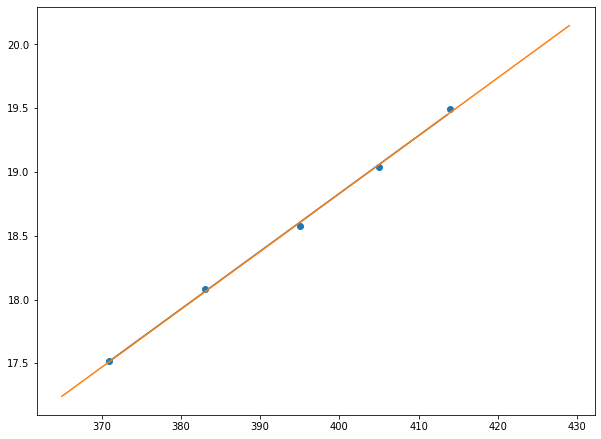

In [37]:
xnew,ynew = linfit(val(magnets),val(true_freqs))
plt.plot(xnew,ynew)
x = arange(365,430,1)
plt.plot(x,line(x,b,a))
plt.scatter(val(magnets),val(true_freqs))

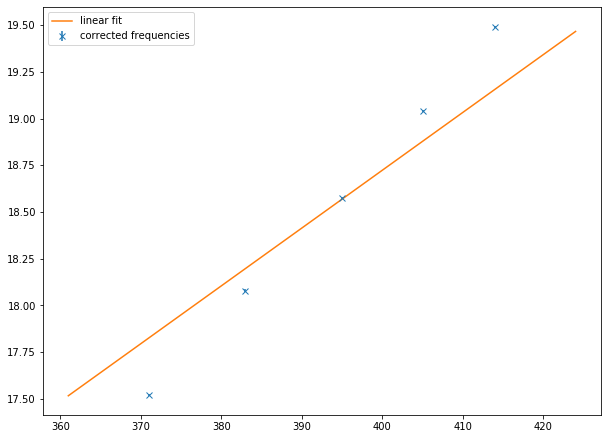

In [38]:
plt.errorbar(val(magnets), val(true_freqs),errr(true_freqs),fmt="x",label="corrected frequencies")
plt.plot(np.linspace(min(val(magnets))-10,max(val(magnets))+10),line(np.linspace(min(val(magnets)),max(val(magnets))),*val(params)),label="linear fit")
plt.legend()
plt.show()

In [39]:
line(1000,*params)

46.03362497453361+/-0.8369315416135747

In [40]:
gamma=params[0]*2*np.pi
gamma2=((true_freqs*1e6)/(array(magnets)*1e-3))*2*np.pi
gamma2

array([295504328.9623438+/-753472.7935595764,
       296595148.9066271+/-782964.8720249006,
       296709096.6126285+/-805312.5744602326,
       295371979.3251755+/-734344.6157519595,
       295820935.09157515+/-719513.4140933465], dtype=object)

In [41]:
df = pd.DataFrame(np.transpose([true_freqs,magnets,gamma2]),
                  columns=[r"Corrected resonance frequencies [Mhz]",r"Measured magnetic fields [mT]",r"$\gamma$"])
df

,Corrected resonance frequencies [Mhz],Measured magnetic fields [mT],$\gamma$
0,18.577+/-0.006,395.0+/-1.0,(2.955+/-0.008)e+08
1,18.079+/-0.007,383.0+/-1.0,(2.966+/-0.008)e+08
2,17.520+/-0.006,371.0+/-1.0,(2.967+/-0.008)e+08
3,19.039+/-0.006,405.0+/-1.0,(2.954+/-0.007)e+08
4,19.492+/-0.006,414.0+/-1.0,(2.958+/-0.007)e+08


In [42]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
{} & Corrected resonance frequencies [Mhz] & Measured magnetic fields [mT] &             \$\textbackslash gamma\$ \\
\midrule
0 &                        18.577+/-0.006 &                   395.0+/-1.0 &  (2.955+/-0.008)e+08 \\
1 &                        18.079+/-0.007 &                   383.0+/-1.0 &  (2.966+/-0.008)e+08 \\
2 &                        17.520+/-0.006 &                   371.0+/-1.0 &  (2.967+/-0.008)e+08 \\
3 &                        19.039+/-0.006 &                   405.0+/-1.0 &  (2.954+/-0.007)e+08 \\
4 &                        19.492+/-0.006 &                   414.0+/-1.0 &  (2.958+/-0.007)e+08 \\
\bottomrule
\end{tabular}



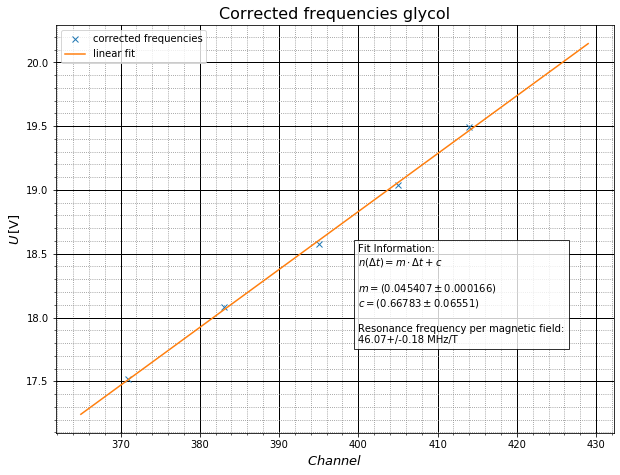

In [43]:
plt.plot(val(magnets), val(true_freqs),"x",label="corrected frequencies")

plt.plot(x,line(x,b,a),label="linear fit")
plt.text(400,17.8,'Fit Information:\n$n(\\Delta t)=m\\cdot \\Delta t +c $\n\n$m=({:.6f}\\pm {:.6f})$\n$c=({:.5f}\\pm {:.5f})$\n\nResonance frequency per magnetic field:\n{:} MHz/T'
         .format(b,ub,a,ua,line(1000,ufloat(b,ub),ufloat(a,ua))),bbox={'facecolor':'white', 'alpha':0.8}, fontsize=10)
#"Resonance frequency per magnetic field:\n{:} \\frac{MHz}{T}".format(line(1000,ufloat(b,ub),ufloat(a,ua))), 

###   Label / Title

plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
plt.xlabel(r'$Channel$', fontsize=13)
plt.title('Corrected frequencies glycol', fontsize=16)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
plt.savefig('glycol.png')
plt.show()

In [49]:
lit =  2.675e8 
def vertrag(x, ux, y):
    """determines, whether your value is compatible with a given value"""
    return np.abs(x - y) / ux


def vergl(x, ux, y, uy):
    """determines, whether two values are compativle"""
    return abs(x - y) / sqrt(ux ** 2 + uy ** 2)


comps = []
vals = val(gamma2)
errrs = errr(gamma2)
for i in range(len(gamma2)):
    comps.append(vertrag(vals[i],errrs[i],lit))

df2 = pd.DataFrame((comps),columns=["compatibility"])

print(df2.to_latex())

\begin{tabular}{lr}
\toprule
{} &  compatibility \\
\midrule
0 &      37.167007 \\
1 &      37.160223 \\
2 &      36.270509 \\
3 &      37.954904 \\
4 &      39.361233 \\
\bottomrule
\end{tabular}

